In [74]:
import os
import pandas as pd
import pickle
import zipfile
from datetime import datetime
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import nltk 
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split

<b><u>Merging the data frames:</b></u>

In [81]:
if not os.path.exists('abstracts_df_eda.csv'):
    with zipfile.ZipFile('../1_eda/abstracts/abstracts_df_eda.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

abstracts_df = pd.read_csv('abstracts_df_eda.csv')

abstracts_df = abstracts_df.drop(['Unnamed: 0'], axis = 1)

abstracts_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,young,young adults,young healthy,young older,younger,younger adults,youth,zone,citation_count,journal
0,9065511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,the journal of neuroscience : the official jou...
1,9084599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,464.0,journal of neurophysiology
2,9114263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,367.0,journal of neurophysiology


In [82]:
metadata_df = pd.read_csv('../1_eda/metadata/metadata_df_eda.csv')
metadata_df = metadata_df.drop(['Unnamed: 0'], axis = 1)

metadata_df.head(3)

,id,title,authors,year_published
0,9065511,Environmental knowledge is subserved by separa...,"Aguirre GK, D'Esposito M",1997
1,9084599,Anatomy of motor learning. I. Frontal cortex a...,"Jueptner M, Stephan KM, Frith CD, Brooks DJ, F...",1997
2,9114263,Multiple nonprimary motor areas in the human c...,"Fink GR, Frackowiak RS, Pietrzyk U, Passingham RE",1997


In [83]:
journals_df = pd.read_csv('../1_eda/journals/journals.csv')  
journals_df = journals_df.drop('Unnamed: 0', axis = 1)
journals_df['journal_lower'] = journals_df['journal'].str.lower()
journals_df = journals_df.drop(['journal'], axis=1)
journals_df = journals_df.rename(columns={'journal_lower': 'journal'})

journals_df.head(3)

,journal_impact_factor,journal_h_index,journal
0,7.1,1025,proceedings of the national academy of science...
1,2.5,435,plos one
2,2.2,381,brain research


In [84]:
data_df = abstracts_df.merge(journals_df, on='journal', how='left')
data_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,young healthy,young older,younger,younger adults,youth,zone,citation_count,journal,journal_impact_factor,journal_h_index
0,9065511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,180.0,the journal of neuroscience : the official jou...,NaN,NaN
1,9084599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,464.0,journal of neurophysiology,1.8,391.0
2,9114263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,367.0,journal of neurophysiology,1.8,391.0


In [85]:
data_df = data_df.merge(metadata_df, on='id', how='inner')
data_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,younger adults,youth,zone,citation_count,journal,journal_impact_factor,journal_h_index,title,authors,year_published
0,9065511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,180.0,the journal of neuroscience : the official jou...,NaN,NaN,Environmental knowledge is subserved by separa...,"Aguirre GK, D'Esposito M",1997
1,9084599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,464.0,journal of neurophysiology,1.8,391.0,Anatomy of motor learning. I. Frontal cortex a...,"Jueptner M, Stephan KM, Frith CD, Brooks DJ, F...",1997
2,9114263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,367.0,journal of neurophysiology,1.8,391.0,Multiple nonprimary motor areas in the human c...,"Fink GR, Frackowiak RS, Pietrzyk U, Passingham RE",1997


Filling NaN values of journal_h_index and journal_impact_factor:

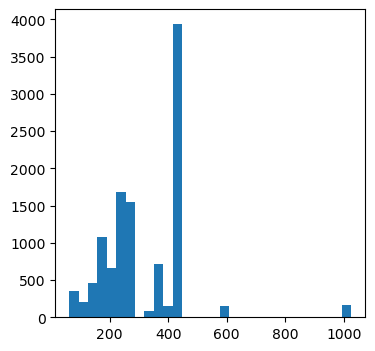

In [7]:
plt.figure(figsize=(4, 4))
plt.hist(data_df['journal_h_index'], bins=30)
plt.show()

The data is right-skewed, we'll use the median to fill in missing values because the median is less sensitive to outliers and extreme values, which in our case are present on the right side

In [86]:
median_value = data_df['journal_h_index'].median()
data_df['journal_h_index'].fillna(median_value, inplace=True)

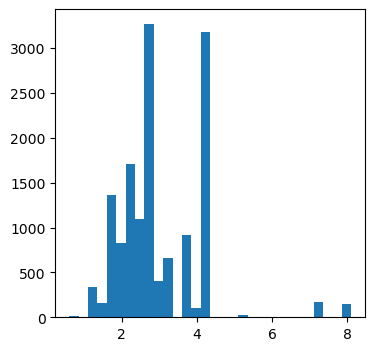

In [10]:
plt.figure(figsize=(4, 4))
plt.hist(data_df['journal_impact_factor'], bins=30)
plt.show()

In [87]:
median_value = data_df['journal_impact_factor'].median()
data_df['journal_impact_factor'].fillna(median_value, inplace=True)

<u><b>Dummy Encoding of journal:</b></u>

In [88]:
data_df = pd.get_dummies(data_df, columns=['journal'])
journal_cols = [col for col in data_df.columns if 'journal_' in col and col not in ['journal_h_index', 'journal_impact_factor']]
data_df[journal_cols] = data_df[journal_cols].astype(int)

data_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,journal_progress in brain research,journal_psychiatry research,journal_psychiatry research. neuroimaging,journal_psychopharmacology,journal_schizophrenia research,journal_schizophrenia research. cognition,journal_social cognitive and affective neuroscience,journal_the european journal of neuroscience,journal_the journal of neuroscience : the official journal of the society for neuroscience,journal_vision research
0,9065511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,9084599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,9114263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


<u> **Feature Engineering:** </u>
<font size=3>
1. Adding 'years_since_publication' feature will provide relative information about how old is the paper.   
Citation count is often heavily influenced by how long the paper has been published, therefore we consider this feature to be beneficial.  

2. Adding 'number_of_authors' feature

2. Converting the data that we have about the paper's authors into 'authors_group_rank' could potentially enhance the model's ability to predict citation counts with greater precision.  
The idea is sub-divided into 2 stages that are applied on the **training** dataset:  
2.1. Calculate Author's Rank: weighted average of citations count across all papers co-authored by the individual.  
The weights are assigned based on the author's position in the list of authors.  
2.2. Calculate Authors Group Rank: weighted average of the authors ranking, again, based on the position of the authors.

 </font>

In [89]:
current_year = datetime.now().year
data_df['years_since_publication'] = current_year - data_df['year_published']
data_df['number_of_authors'] = data_df['authors'].apply(lambda x: len(x.split(',')))

data_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,journal_psychiatry research. neuroimaging,journal_psychopharmacology,journal_schizophrenia research,journal_schizophrenia research. cognition,journal_social cognitive and affective neuroscience,journal_the european journal of neuroscience,journal_the journal of neuroscience : the official journal of the society for neuroscience,journal_vision research,years_since_publication,number_of_authors
0,9065511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,27,2
1,9084599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,27,6
2,9114263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,27,4


In [90]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=0)

In [42]:
def get_weights(n: int, quotinent: float) -> list[float]:
    if n == 1:
        return [1]
    
    first_author_weight = _solve_weights_equation(n, quotinent)
    last_author_weight = first_author_weight * quotinent

    middle_authors_weights = [last_author_weight * (quotinent**i) for i in range(1, n-1)]
    return [first_author_weight] + middle_authors_weights + [last_author_weight]

def _solve_weights_equation(n_value: int, quotinent: float) -> float:
    x = sp.symbols('x')
    n = sp.symbols('n', integer=True)

    equation = sp.Eq(x * (1- (quotinent)**n) / (1 - quotinent), 1) # sum of geometric series
    solution = sp.solve(equation, x)

    return solution[0].subs(n, n_value)

In [43]:
DEFAULT_QUOTINENT = 3/5

def get_authors_group_rank_mapping(df: pd.DataFrame, author_rank_mapping: dict[str, float]) -> dict[int, float]:
    authors_group_rank = {}

    row_id_authors = df[['id', 'authors']]
    mean_author_rank = np.mean(list(author_rank_mapping.values()))

    for _, row in row_id_authors.sort_index().iterrows():
        id = row['id']
        authors = [author_name.strip() for author_name in row['authors'].split(',')]
        weights = get_weights(len(authors), DEFAULT_QUOTINENT)

        rank = 0
        for i, author in enumerate(authors):
            author_rank = author_rank_mapping.get(author, 0)
            if author_rank == 0:
                author_rank = mean_author_rank
            rank += author_rank * weights[i]

        authors_group_rank[id] = rank

    return authors_group_rank

def get_author_rank_mapping() -> dict[str, float]:
    author_rank_mapping = {}

    paper_authors_citation_count = train_df[['authors', 'citation_count']]
    
    for _, row in paper_authors_citation_count.sort_index().iterrows():
        citation_count = row['citation_count']
        authors = [author_name.strip() for author_name in row['authors'].split(',')]
        authors_number = len(authors)
        weights = get_weights(authors_number, DEFAULT_QUOTINENT)

        for i, author in enumerate(authors):
            author_rank_mapping.setdefault(author, []).append(citation_count * weights[i])

    return {author: sum(ranks) / len(ranks) for author, ranks in author_rank_mapping.items()}


Adding <b>author group rank</b> column:
* If you would like to run the code quickly - leave the comments and run the uncommented code in the following sections.  
For reproducing the calculations - uncomment and run the the code sections one by one

In [17]:
# author_rank_mapping = get_author_rank_mapping()
# pd.Series(author_rank_mapping).to_frame().to_csv('author_rank_mapping.csv')

# author_rank_mapping = pd.read_csv('author_rank_mapping.csv', index_col=0).squeeze().to_dict()
# train_authors_group_rank_mapping = get_authors_group_rank_mapping(train_df, author_rank_mapping)
# pd.Series(train_authors_group_rank_mapping).to_frame().to_csv('train_authors_group_rank_mapping.csv')

In [91]:
train_authors_group_rank_mapping = pd.read_csv('train_authors_group_rank_mapping.csv', index_col=0).squeeze().to_dict()
train_df['authors_group_rank'] = train_df['id'].map(train_authors_group_rank_mapping)

In [19]:
# author_rank_mapping = pd.read_csv('author_rank_mapping.csv', index_col=0).squeeze().to_dict()
# test_authors_group_rank_mapping = get_authors_group_rank_mapping(test_df, author_rank_mapping)
# pd.Series(test_authors_group_rank_mapping).to_frame().to_csv('test_authors_group_rank_mapping.csv')

In [92]:
test_authors_group_rank_mapping = pd.read_csv('test_authors_group_rank_mapping.csv', index_col=0).squeeze().to_dict()
test_df['authors_group_rank'] = test_df['id'].map(test_authors_group_rank_mapping)

Adding columns of <b>prominent</b> and <b>prevalent</b> authors <b>(by training set data)</b>:

In [93]:
author_rank_df = pd.read_csv('author_rank_mapping.csv', header=None, names=['Author', 'Rank'])
author_rank_df.describe()

,Rank
count,26446.000000
mean,11.972858
std,35.637498
min,0.000000
25%,1.647381
50%,5.161765
75%,13.315869
max,3764.013829


In [94]:
author_rank_df = author_rank_df.sort_values(by='Rank', ascending=False)
top_prominent_200_authors = set(author_rank_df['Author'].head(200).tolist())

In [94]:
author_rank_df

,Author,Rank
18036,Deprez S,3764.013829
19865,Pulcu E,1116.752576
18023,Kurby CA,1051.875000
13194,Yeo BT,974.764189
19867,Ermer E,908.580397
...,...,...
25088,YorkWilliams SL,0.000000
22045,Appelgren A,0.000000
22428,Pappas I,0.000000
22429,Pardalos P,0.000000


In [48]:
def get_author_occurrences_mapping() -> dict[str, int]:
    author_occurrences = {}

    authors_groups = train_df[['authors']]
    
    for _, row in authors_groups.sort_index().iterrows():
        authors = [author_name.strip() for author_name in row['authors'].split(',')]

        for _, author in enumerate(authors):
            author_occurrences[author] = author_occurrences.get(author, 0) + 1

    return author_occurrences

In [28]:
# author_occurrences_mapping = get_author_occurrences_mapping()
# pd.Series(author_occurrences_mapping).to_frame().to_csv('author_occurrences_mapping.csv')

In [95]:
author_occurences_df = pd.read_csv('author_occurrences_mapping.csv', header=None, names=['Author', 'Occurrences'])
author_occurences_df = author_occurences_df.sort_values(by='Occurrences', ascending=False)
top_prevalent_200_authors = set(author_occurences_df['Author'].head(200).tolist())

In [96]:
prominent_prevalent_authors = top_prominent_200_authors.union(top_prevalent_200_authors)

In [19]:
def get_id_prominent_prevalent_authors(df: pd.DataFrame, prominent_prevalent_authors: set[str]) -> dict[int, dict[str, int]]:
    id_prominent_prevalent_authors = {}

    id_authors_groups = df[['id','authors']]
    
    for _, row in id_authors_groups.sort_index().iterrows():
        id = row['id']
        authors = [author for author in [author_name.strip() for author_name in row['authors'].split(',')] if author in prominent_prevalent_authors]

        if authors:
            _prominent_prevalent_authors = id_prominent_prevalent_authors.setdefault(id, {})

            for _, author in enumerate(authors):
                _prominent_prevalent_authors[author] = 1


    return id_prominent_prevalent_authors

In [97]:
id_prominent_prevalent_authors_train = get_id_prominent_prevalent_authors(train_df, prominent_prevalent_authors)
id_prominent_prevalent_authors_test = get_id_prominent_prevalent_authors(test_df, prominent_prevalent_authors)

In [33]:
len(prominent_prevalent_authors)

400

In [98]:
id_prominent_prevalent_authors_train_df = pd.DataFrame(id_prominent_prevalent_authors_train).T
train_df = train_df.join(id_prominent_prevalent_authors_train_df, on='id') # left join

train_df[list(prominent_prevalent_authors)] = train_df[list(prominent_prevalent_authors)].fillna(0).astype(int)
train_df.head(3)


,id,001,01,05,10,100,11,12,12 healthy,13,...,Gaudet LM,Steele VR,Eckhardt AL,Biessmann F,Oh A,Horvath JC,Carter O,Sanz-Leon P,Rice GE,Braun U
1351,15850739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
13288,28077311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9477,23968735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
id_prominent_prevalent_authors_test_df = pd.DataFrame(id_prominent_prevalent_authors_test).T
test_df = test_df.join(id_prominent_prevalent_authors_test_df, on='id')
missing_columns_prominent_prevalent_authors = [a for a in prominent_prevalent_authors if a not in test_df.columns]

missing_columns_df = pd.DataFrame(0, index=test_df.index, columns=missing_columns_prominent_prevalent_authors)

test_df = pd.concat([test_df, missing_columns_df], axis=1)
test_prominent_prevalent_authors = [col for col in prominent_prevalent_authors if col not in missing_columns_prominent_prevalent_authors]
test_df[test_prominent_prevalent_authors] = test_df[test_prominent_prevalent_authors].fillna(0).astype(int)

test_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,Shizgal P,Adcock JE,Guillot A,Prevost C,Canterberry M,O'Reilly JX,Snijders AH,Larson-Prior LJ,Bantick SJ,Herringa RJ
9469,23964193,0.0,0.062086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2090,16650777,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5578,20663646,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
with open('prominent_prevalent_authors.pkl', 'wb') as f:
    pickle.dump(prominent_prevalent_authors, f)

Reorder columns:

In [101]:
test_df = test_df[train_df.columns]

In [102]:
test_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,Gaudet LM,Steele VR,Eckhardt AL,Biessmann F,Oh A,Horvath JC,Carter O,Sanz-Leon P,Rice GE,Braun U
9469,23964193,0.0,0.062086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2090,16650777,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5578,20663646,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
train_df.head(3)

,id,001,01,05,10,100,11,12,12 healthy,13,...,Gaudet LM,Steele VR,Eckhardt AL,Biessmann F,Oh A,Horvath JC,Carter O,Sanz-Leon P,Rice GE,Braun U
1351,15850739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
13288,28077311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9477,23968735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Dropping Authors:

In [104]:
train_df = train_df.drop(['authors'], axis = 1)
test_df = test_df.drop(['authors'], axis = 1)

Adding <b>semantic cluster</b> by title:

In [58]:
def sentence_to_mean_vector(sentence: str, model: Word2Vec) -> np.ndarray:
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [106]:
stop_words = set(stopwords.words('english'))
train_df['semantic_processeing'] = train_df['title'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

model = Word2Vec(train_df['semantic_processeing'], min_count=1)

train_df['semantic_vector'] = train_df['semantic_processeing'].apply(lambda x: sentence_to_mean_vector(x, model))

# Convert list of vectors into 2D array for K-means input
X = np.array(train_df['semantic_vector'].tolist())


C:\Users\chenr\AppData\Local\Temp\ipykernel_3564\2308901016.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['semantic_processeing'] = train_df['title'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])
C:\Users\chenr\AppData\Local\Temp\ipykernel_3564\2308901016.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['semantic_vector'] = train_df['semantic_processeing'].apply(lambda x: sentence_to_mean_vector(x, model))


In [107]:
linked = linkage(X, method='ward')

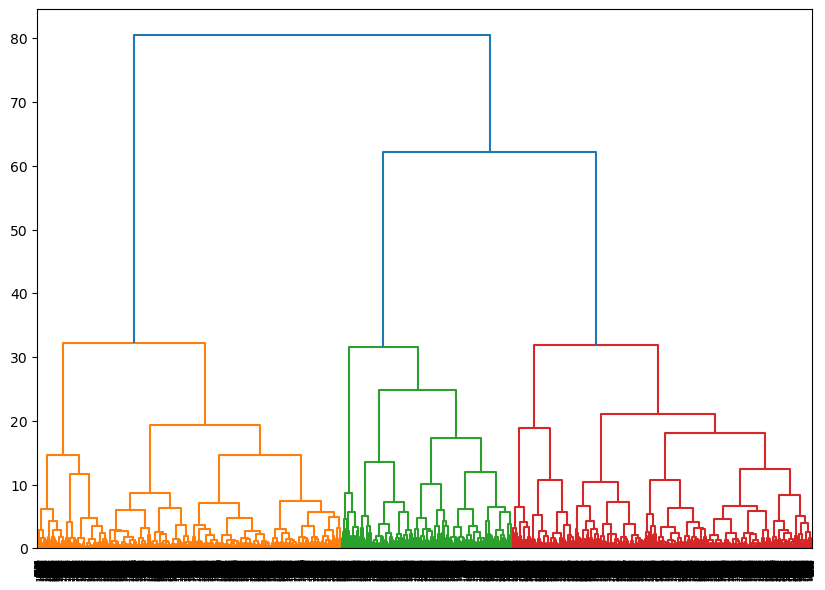

In [108]:
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.show()

In [ ]:
clusters = fcluster(linked, 5, criterion='distance')

num_clusters = len(np.unique(clusters))

By using the dendogram, we see that cutting at height of 5 will provide 47 clusters.  
Therefore we decide to use K-MEANS with 47 clusters:

In [110]:
kmeans = KMeans(n_clusters=47, random_state=0).fit(X)

c:\Users\chenr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [111]:
train_df['semantic_cluster'] = kmeans.labels_
train_df = train_df.drop(['semantic_vector', 'semantic_processeing', 'title'], axis=1)
train_df.head()

,id,001,01,05,10,100,11,12,12 healthy,13,...,Steele VR,Eckhardt AL,Biessmann F,Oh A,Horvath JC,Carter O,Sanz-Leon P,Rice GE,Braun U,semantic_cluster
1351,15850739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,20
13288,28077311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,37
9477,23968735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,25
2529,17240164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
6022,21175881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8


In [112]:
test_df['semantic_processeing'] = test_df['title'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

test_df['semantic_vector'] = test_df['semantic_processeing'].apply(lambda x: sentence_to_mean_vector(x, model))

# Convert list of vectors into 2D array for K-means input
X_test = np.array(test_df['semantic_vector'].tolist())

test_df['semantic_cluster'] = kmeans.predict(X_test)
test_df = test_df.drop(['semantic_vector', 'semantic_processeing', 'title'], axis=1)
test_df.head()

C:\Users\chenr\AppData\Local\Temp\ipykernel_3564\4226019747.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['semantic_processeing'] = test_df['title'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])
C:\Users\chenr\AppData\Local\Temp\ipykernel_3564\4226019747.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['semantic_vector'] = test_df['semantic_processeing'].apply(lambda x: sentence_to_mean_vector(x, model))
C:\Users\chenr\AppData\Local\Temp\ipykern

,id,001,01,05,10,100,11,12,12 healthy,13,...,Steele VR,Eckhardt AL,Biessmann F,Oh A,Horvath JC,Carter O,Sanz-Leon P,Rice GE,Braun U,semantic_cluster
9469,23964193,0.0,0.062086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,42
2090,16650777,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5578,20663646,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,41
10304,24675869,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,45
13381,28194095,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,30


In [113]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

with zipfile.ZipFile('train_df.zip', 'w') as zf:
    zf.write('train_df.csv')

with zipfile.ZipFile('test_df.zip', 'w') as zf:
    zf.write('test_df.csv')


os.remove('train_df.csv')    
os.remove('test_df.csv')    